In [1]:
from dateutil.relativedelta import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
catalog = pd.read_csv("../helper/catalog.csv")
data = pd.read_csv("../output/2020-06-01_database_tf.csv", parse_dates=["date"])
ys = ["x_world.sa", "x_vol_world2.sa", "x_servs_world.sa"]

In [32]:
# generating vintage dataset
def offset_series(series, offset):
    tmp = series
    tmp[-offset:] = np.nan
    return tmp
    
def gen_vintage(data, catalog, start_date, end_date):
    tmp = data.loc[lambda x: (x.date >= start_date) & (x.date <= end_date), :]
    offsets = [
        catalog.loc[catalog.code == x,"publication_lag"].values[0]
            if len(catalog.loc[catalog.code == x,"publication_lag"]) > 0 
            else catalog.loc[catalog.code == x[:-3],"publication_lag"].values[0]
        for x in data.columns[1:]
    ]
    for i in range(1, len(tmp.columns)):
        tmp.iloc[:,i] = offset_series(tmp.iloc[:,i], offsets[i-1])
    return tmp

def interpolate(data, method):
    if method == "none":
        return data
    elif method == "linear":
        return data.interpolate()
    elif method == "mean":
        return data.fillna(data.mean())

def gen_target_data(data, catalog, target, start_date, end_date, interp_method="none", ragged_ends=True):
    vintage = gen_vintage(data, catalog, start_date, end_date)
    if target == "x_world.sa":
        catalog_col = "octave_value"
    elif target == "x_vol_world2.sa":
        catalog_col = "octave_volume"
    elif target == "x_servs_world.sa":
        catalog_col = "octave_services"
    tmp = vintage.loc[:, pd.unique(["date"] + catalog.loc[~pd.isna(catalog[catalog_col]), catalog_col].to_list())]
    tmp = interpolate(data, interp_method)
    if ragged_ends:
        tmp = gen_vintage(tmp, catalog, start_date, end_date).set_index("date").dropna(how="all")
    else:
        tmp = tmp.set_index("date").dropna(how="all")
    return tmp.loc[tmp.index > "2002-01-01",:]

# Running model vintage

In [ ]:
# params
start_date = "2002-01-01"
global_end_date = "2020-06-01"
target = "x_world.sa"
model_num = "model_3"
    
end_date = pd.to_datetime("2018-01-01")
results = pd.DataFrame({"date": pd.date_range(end_date, global_end_date, freq="MS")})
for col in ["actual", "+3", "+2", "+1", "0", "-1", "-2"]:
    results[col] = np.nan

while end_date <= pd.to_datetime(global_end_date):
    print(end_date)
    
    # model
    x = gen_target_data(data, catalog, target, start_date, end_date, interp_method="none", ragged_ends=True)
    mod = sm.tsa.DynamicFactor(x, k_factors=1, factor_order=1, error_order=1)
    initial_res = mod.fit(method='powell', disp=False)
    res = mod.fit(initial_res.params, disp=False)
    res = mod.fit(disp=False)
    pred = res.predict().append(res.forecast(5))
    
    results.loc[results.date == (end_date + relativedelta(months = -1)), "+1"] = pred.loc[pred.index == (end_date + relativedelta(months = -1)), target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = -2)), "+2"] = pred.loc[pred.index == (end_date + relativedelta(months = -2)), target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = -3)), "+3"] = pred.loc[pred.index == (end_date + relativedelta(months = -3)), target].values[0]
    results.loc[results.date == end_date, "0"] = pred.loc[pred.index == end_date, target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = +1)), "-1"] = pred.loc[pred.index == (end_date + relativedelta(months = +1)), target].values[0]
    results.loc[results.date == (end_date + relativedelta(months = +2)), "-2"] = pred.loc[pred.index == (end_date + relativedelta(months = +2)), target].values[0]
    
    end_date += relativedelta(months = +1)
    
results = results.merge(data.loc[:, ["date", target]], how="left", on ="date")
results.actual = results[target]
results = results.drop([target], axis=1)

results.to_csv(f"python_dfm_results/{model_num}.csv", index=False)

# Specific model

In [ ]:
model_num = 1

# plotting out of sample results
print(f"+3 MAE: {np.mean(np.abs(results.actual - results['+3'])).round(5)}")
print(f"+2 MAE: {np.mean(np.abs(results.actual - results['+2'])).round(5)}")
print(f"+1 MAE: {np.mean(np.abs(results.actual - results['+1'])).round(5)}")
print(f"0 MAE: {np.mean(np.abs(results.actual - results['0'])).round(5)}")
print(f"-1 MAE: {np.mean(np.abs(results.actual - results['-1'])).round(5)}")
print(f"-2 MAE: {np.mean(np.abs(results.actual - results['-2'])).round(5)}")

tmp = results
tmp = tmp.loc[(~pd.isna(tmp.actual)) | (tmp.date == "2020-03-01") | (tmp.date == "2020-06-01"),:].reset_index(drop=True)
plt.plot(tmp.date, tmp.actual, label="actual")
plt.plot(tmp.date, tmp["0"], label="0")
plt.plot(tmp.date, tmp["-1"], label="-1")
plt.plot(tmp.date, tmp["-2"], label="-2")
plt.plot(tmp.date, tmp["+1"], label="+1")
# plt.plot(tmp.date, tmp["+2"], label="+2")
# plt.plot(tmp.date, tmp["+3"], label="+3")
plt.title(f"Model {model_num} out of sample")
plt.legend();

In [ ]:
# plotting in sample results
x = gen_target_data(data, catalog, target, "2002-01-01", "2020-06-01", interp_method="linear", ragged_ends=True)
mod = sm.tsa.DynamicFactor(x, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
pred = res.predict().append(res.forecast(5))

tmp = pred["x_world.sa"].reset_index().merge(data.loc[:,["date", "x_world.sa"]], how="left", left_on="index", right_on="date").drop("index", axis=1)
tmp.columns = ["pred", "date", "actual"]
tmp = tmp.loc[~pd.isna(tmp.actual), :].reset_index(drop=True)

print(f"MAE: {np.mean(np.abs(tmp.pred - tmp.actual)).round(5)}")

plt.plot(tmp.date, tmp.pred, label="pred")
plt.plot(tmp.date, tmp.actual, label="actual")
plt.title(f"Model {model_num} in sample")
plt.legend();

# no missing ML testing

In [163]:
# generating data
test_date = "2018-01-01"
x = gen_target_data(data, catalog, target, "2002-01-01", "2020-06-01", interp_method="linear", ragged_ends=True)
x = x.loc[~pd.isna(x["x_world.sa"]),:]
x = x.fillna(x.mean())
x_train = x.loc[x.index < test_date, :].drop(["x_world.sa"], axis=1)
x_test = x.loc[x.index >= test_date, :].drop(["x_world.sa"], axis=1)
y_train = x.loc[x.index < test_date, "x_world.sa"]
y_test = x.loc[x.index >= test_date, "x_world.sa"]

Insample MAE: 0.01214
Outsample MAE: 0.00789


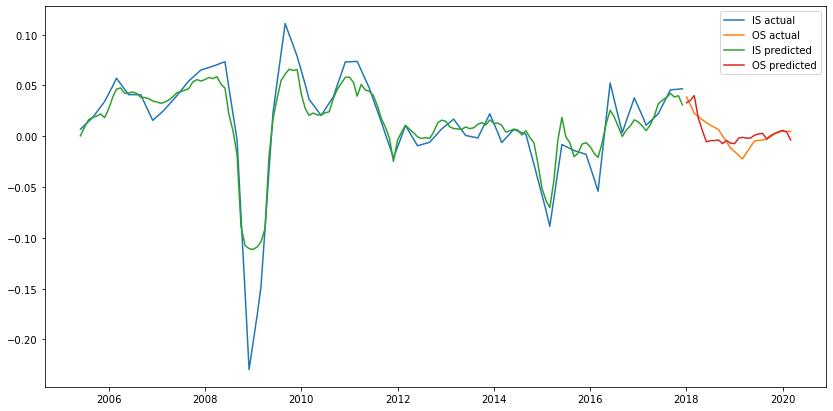

In [185]:
# model
#from sklearn.tree import DecisionTreeRegressor
#model = DecisionTreeRegressor(random_state=10)
#from sklearn.ensemble import GradientBoostingRegressor
#model = GradientBoostingRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, criterion = "mae", min_samples_leaf = 5)

model.fit(x_train, y_train)
insample = pd.Series(model.predict(x_train))
insample.index = y_train.index
pred = pd.Series(model.predict(x_test))
pred.index = y_test.index

# performance
print(f"Insample MAE: {np.abs(insample - y_train).mean().round(5)}")
print(f"Outsample MAE: {np.abs(pred - y_test).mean().round(5)}")
plt.plot(y_train, label="IS actual")
plt.plot(y_test, label="OS actual")
plt.plot(insample, label="IS predicted")
plt.plot(pred, label="OS predicted")
plt.legend();

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [215]:
np.reshape(tmp, (tmp.shape[0], 1, tmp.shape[1])).shape

(151, 132)

In [222]:
tmp = np.matrix(x_train)
tmp = tmp[:, np.newaxis, :]

In [ ]:
look_back = 1
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(tmp, y_train, epochs=100, batch_size=1, verbose=2)